In [1]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(g):
    nx_g = g.to_networkx()
    # 创建matplotlib图形对象
    fig, ax = plt.subplots()
    # 可视化networkx图
    pos = nx.kamada_kawai_layout(nx_g)
    nx.draw(nx_g, pos=pos, with_labels=True, ax=ax)
    plt.show()

Graph(num_nodes=8, num_edges=9,
      ndata_schemes={}
      edata_schemes={})
Graph(num_nodes=8, num_edges=18,
      ndata_schemes={}
      edata_schemes={})


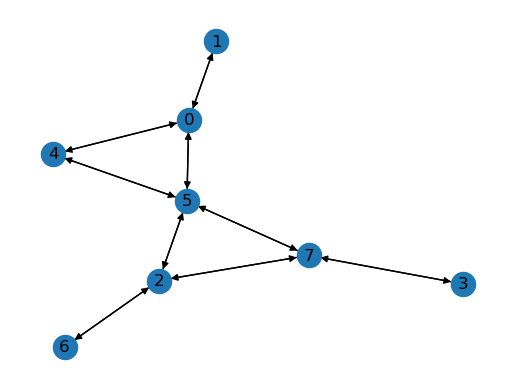

In [2]:
# 构建无向图
# g = dgl.graph(([0, 1, 1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15],
#                [1, 2, 3, 4, 5, 0, 0, 9, 11, 14, 16, 17, 18, 19, 18, 17, 14, 16, 18, 19]),
#               num_nodes=20)
# 生成随机边
import random
num_nodes=8
edges = []
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if random.random() < 0.3:  # 控制边的密度，这里是30%
            edges.append((i, j))

src, dst = zip(*edges)
# self_edges = (g.nodes(), g.nodes())
# g.add_edges(*self_edges)
g = dgl.graph((src, dst), num_nodes=num_nodes)
print(g)
g = dgl.to_bidirected(g)
print(g)
# 创建图

visualize_graph(g)


In [52]:
# 2. 随机选择一些中心点
central_nodes = torch.tensor([3,5], dtype=torch.int64)

# 3. 构造一个onehot矩阵
def one_hot(y, num_class):
    return torch.eye(num_class)[y]
onehot_cn = one_hot(central_nodes, g.num_nodes()) # 2 * 8
print(onehot_cn)



tensor([[0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]])


In [57]:

# 4. 乘邻接矩阵 (乘k次表示取出k层邻居)
# onehot_cn * adj  # 2 * 8 x 8 * 8 = 2 * 8
# 输出g的邻接矩阵
print(g.adjacency_matrix())

# 生成邻接矩阵
adj_matrix = g.adjacency_matrix()

# 将稀疏矩阵转换为标准矩阵
dense_matrix = adj_matrix.to_dense()
dense_matrix[torch.arange(g.num_nodes()), torch.arange(g.num_nodes())]=1
# 打印标准矩阵
print(dense_matrix)
sub_graph_set=onehot_cn
for i in range(3):
    sub_graph_set=torch.matmul(sub_graph_set, dense_matrix)
print(sub_graph_set)


tensor(indices=tensor([[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 5,
                        6, 6, 6, 6, 6, 7, 7],
                       [2, 5, 6, 4, 5, 0, 3, 5, 6, 7, 2, 4, 1, 3, 6, 0, 1, 2, 6,
                        0, 2, 4, 5, 7, 2, 6]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(8, 8), nnz=26, layout=torch.sparse_coo)
tensor([[1., 0., 1., 0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1., 1., 1.],
        [0., 0., 1., 0., 0., 0., 1., 1.]])
tensor([[ 6.,  4., 10.,  7.,  8.,  7.,  9.,  5.],
        [17.,  9., 20.,  7.,  9., 19., 21., 10.]])


In [61]:
# 5. 邻接矩阵中大于1的值表示子图中包含该点，大于1的部分变为1，每行代表一个子图
sub_graph=torch.where(sub_graph_set != 0, torch.tensor(1), torch.tensor(0))
remainder_graph=torch.where(torch.sum(sub_graph_set, dim=0) != 0, torch.tensor(0), torch.tensor(1))
print(sub_graph)
print(remainder_graph)
# 将所有的子图节点全部合为集合 m 个子图，1 * m x 5中的结果，大于1的部分变为1

# 6. 训练，所有子图一起输入gcn, 用张量积取得特征

# 7. 训练完后，矩阵为 8 * 256

# 8. 2 * 8 x 8*256

tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


/tmp/ipykernel_7822/139990173.py:175: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/opt/conda/envs/graph/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


1.10.1
Graph(num_nodes=12, num_edges=32,
      ndata_schemes={}
      edata_schemes={})


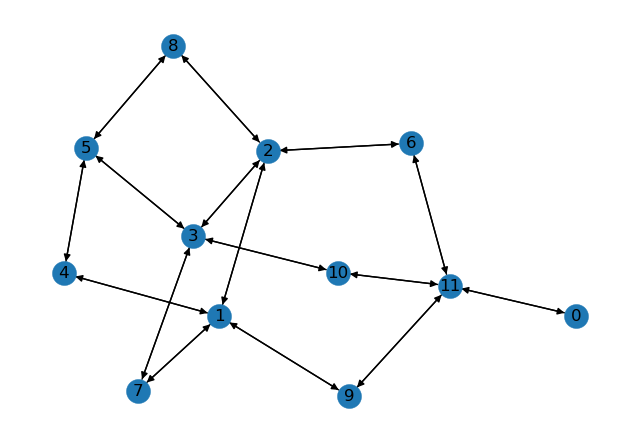

central_nodes: tensor([0], device='cuda:0')
mask time: 0.018578767776489258
mask_test time: 0.0032186508178710938
central_nodes: tensor([7], device='cuda:0')
mask time: 0.006195783615112305
mask_test time: 0.004872560501098633
central_nodes: tensor([8], device='cuda:0')
mask time: 0.014714956283569336
mask_test time: 0.005325794219970703
central_nodes: tensor([8], device='cuda:0')
mask time: 0.006336212158203125
mask_test time: 0.01625657081604004
central_nodes: tensor([7], device='cuda:0')
mask time: 0.01671457290649414
mask_test time: 0.010356426239013672
central_nodes: tensor([8], device='cuda:0')
mask time: 0.005228519439697266
mask_test time: 0.003682851791381836
central_nodes: tensor([9], device='cuda:0')
mask time: 0.006265163421630859
mask_test time: 0.0036928653717041016
central_nodes: tensor([3], device='cuda:0')
mask time: 0.006365537643432617
mask_test time: 0.0028562545776367188
central_nodes: tensor([8], device='cuda:0')
mask time: 0.010096311569213867
mask_test time: 0.0

In [22]:
# 对mask及其依赖函数的测试
import functools
import time
import dgl
import torch
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(g):
    nx_g = g.to_networkx()
    # 创建matplotlib图形对象
    fig, ax = plt.subplots()
    # 可视化networkx图
    pos = nx.kamada_kawai_layout(nx_g)
    nx.draw(nx_g, pos=pos, with_labels=True, ax=ax)
    plt.show()

def readDimacsInstance(filename):
    # print filename
    g = dgl.DGLGraph()
    fin = open(filename, 'r')
    for line in fin.readlines():
        sline = line.split()
        if line.startswith('e'):
            g.add_edges(int(sline[1]), int(sline[2]))
    fin.close()
    return g

#     return mask_nodes
@functools.lru_cache(maxsize=16)
def get_neighbors_right(graph:dgl.DGLGraph, nodes:torch.Tensor, adj_matrix:torch.Tensor=None):
    """获得一个中心点列表中所有中心点的邻居，不包括中心点本身，且去重
    Args:
        graph (dgl.DGLGraph): 图对象
        nodes (torch.Tensor): 中心节点张量，1*nodes_num
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    assert nodes.is_cuda == True
    # # print(type(graph))
    adj_matrix = graph.adjacency_matrix()
    # 判断adj_matrix的是否在GPU上
    # # print(adj_matrix.is_cuda)
    adj_matrix = adj_matrix.to(nodes.device)
    # adj_matrix = adj_matrix.to(nodes.device)
    # # print(adj_matrix.device)
    assert adj_matrix.is_cuda == True

    # 获得这些节点的邻居
    neighbors = adj_matrix.index_select(0, nodes)
    # 压缩稀疏矩阵
    neighbors = neighbors.coalesce()
    # neighbors.indices()返回一个2*neighbors_num的矩阵，2 * neighbors_num，第二行是所有邻居节点标号的横向拼接
    unique_neighbors = torch.unique(neighbors.indices()[1])

    return unique_neighbors

# 多重递归获得邻居节点
@functools.lru_cache(maxsize=16)
def get_all_neighbors_right(graph:dgl.DGLGraph, nodes:torch.Tensor, depth:int, adj_matrix:torch.Tensor=None):
    """多重递归获得邻居节点集合张量（逻辑上是集合，物理数据结构为torch.Tensor），且去重
    Args:
        graph (dgl.DGLGraph): 输入图
        nodes (torch.Tensor): 中心节点集合张量，1*nodes_num
        depth (int): 递归深度，为0时相当于点遮盖，直接返回nodes
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    if depth < 0:
        return torch.Tensor([]).to(nodes.device)
    if depth == 0:
        return nodes
    else:
        neighbors = get_neighbors_right(graph, nodes)
        neighbors = torch.cat((neighbors, nodes), dim=0)
        neighbors = torch.unique(neighbors)
        return get_all_neighbors_right(graph, neighbors, depth-1)



#     return mask_nodes
@functools.lru_cache(maxsize=16)
def get_neighbors(graph:dgl.DGLGraph, nodes:torch.Tensor, adj_matrix:torch.Tensor=None):
    """获得一个中心点列表中所有中心点的邻居，不包括中心点本身，且去重
    Args:
        graph (dgl.DGLGraph): 图对象
        nodes (torch.Tensor): 中心节点张量，1*nodes_num
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    assert nodes.is_cuda == True
    ## 用矩阵运算的方式找邻居
    one_hot_central_nodes = torch.eye(adj_matrix.shape[0]).to(nodes.device)[nodes]
    neighbors_idx = (one_hot_central_nodes @ adj_matrix).nonzero()
    neighbors_idx = neighbors_idx[:,1]
    unique_neighbors = torch.unique(neighbors_idx)

    return unique_neighbors

# 多重递归获得邻居节点
@functools.lru_cache(maxsize=16)
def get_all_neighbors(graph:dgl.DGLGraph, nodes:torch.Tensor, depth:int, adj_matrix:torch.Tensor=None):
    """多重递归获得邻居节点集合张量（逻辑上是集合，物理数据结构为torch.Tensor），且去重
    Args:
        graph (dgl.DGLGraph): 输入图
        nodes (torch.Tensor): 中心节点集合张量，1*nodes_num
        depth (int): 递归深度，为0时相当于点遮盖，直接返回nodes
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    if adj_matrix == None:
        adj_matrix = graph.adjacency_matrix().to_dense().to(nodes.device)
    if depth < 0:
        return torch.Tensor([]).to(nodes.device)
    if depth == 0:
        return nodes
    else:
        neighbors = get_neighbors(graph, nodes, adj_matrix)
        neighbors = torch.cat((neighbors, nodes), dim=0)
        neighbors = torch.unique(neighbors)
        return get_all_neighbors(graph, neighbors, depth-1, adj_matrix)



def mask(g:dgl.DGLGraph, x:torch.Tensor, num, depth, ring_width, get_all_neighbors, central_nodes=None):
    """遮盖子图，返回遮盖节点集合和中心节点集合
    Args:
        g (dgl.DGLGraph): 输入图
        x (torch.Tensor): 特征张量
        num (int): 随机遮盖的子图数量（中心点数量）
        depth (int, optional): 遮盖节点的邻居深度. Defaults to 1.
    Returns:
        torch.Tensor: mask_nodes, 遮盖节点集合
        torch.Tensor: central_nodes, 中心节点集合，可以去除，仅用在需要查看中心节点特征的情况下，猜测当gcn层数为3时，递归深度低于3就可能导致中心节点特征丢失 todo
    """
    assert 1 <= ring_width <= depth + 1, "ring_width must be in [1, depth + 1]"
    num_nodes = g.num_nodes()
    adj_matrix = g.adjacency_matrix().to_dense().to(x.device)

    if central_nodes == None:
        perm = torch.randperm(num_nodes, device=x.device)
        central_nodes = perm[: num]

    # print(central_nodes.device)
    assert type(central_nodes) == torch.Tensor
    # 判断central_nodes的shape为1*num
    central_nodes = central_nodes.to(x.device)
    # print(nodes)
    assert central_nodes.is_cuda == True

    # 外圆节点集合(含中心点)
    connected_nodes_out = get_all_neighbors(g, central_nodes, depth, adj_matrix)
    assert type(connected_nodes_out) == torch.Tensor
    mask_nodes_out = torch.cat((central_nodes, connected_nodes_out), dim=0)
    mask_nodes_out = torch.unique(mask_nodes_out)

    # 内圆节点集合(含中心点)
    not_mask_nodes = get_all_neighbors(g, central_nodes,depth - ring_width, adj_matrix)
    not_mask_nodes = torch.cat((central_nodes, not_mask_nodes), dim=0)
    not_mask_nodes = torch.unique(not_mask_nodes)

    # 环形应遮盖节点集合，有于torch的集合操作，返回的mask_nodes一定是无重复的
    # mask_nodes = torch.masked_select(mask_nodes_out, torch.isin(mask_nodes_out, not_mask_nodes))
    mask_nodes = torch.masked_select(mask_nodes_out, torch.logical_not(torch.isin(mask_nodes_out, not_mask_nodes)))

    return mask_nodes, central_nodes

import torch
import networkx as nx
import matplotlib.pyplot as plt
import dgl
# import numpy as np

plt.style.use('seaborn')

print(torch.__version__)
g = dgl.DGLGraph()

# # 小型测试图
# g.add_edges(
#     [1,1,2,2,4,5,5, 0],
#     [7,3,3,4,5,8,6, 7]
# )


# 大型测试图
## 加载 col 格式的图数据集
g = readDimacsInstance("temp.col")
## 将数据集转换为 dgl.graph 对象

g = dgl.to_bidirected(g)

print(g)

visualize_graph(g)

g = g.to(torch.device('cuda'))
temp_tensor = torch.tensor([1,2,3,4,5,6,7,8,9,10]).to(torch.device('cuda'))

# # 矩阵法找邻居原型demo
# central_nodes = torch.tensor([1], dtype=torch.int64).to(torch.device('cuda'))
# print("central_nodes:", central_nodes)
# print(g.adjacency_matrix().to_dense())
# adj_matrix = g.adjacency_matrix().to_dense()
# ## 用矩阵运算的方式找邻居
# one_hot_central_nodes = torch.eye(adj_matrix.shape[0])[central_nodes]
# print(one_hot_central_nodes)
# print(one_hot_central_nodes @ adj_matrix)
# neighbors_idx = (one_hot_central_nodes @ adj_matrix).nonzero()
# neighbors_idx = neighbors_idx[:,1]
# print(neighbors_idx)
# neighbors_idx2 = (one_hot_central_nodes @ adj_matrix @ adj_matrix).nonzero()
# neighbors_idx2 = neighbors_idx2[:,1]
# print(neighbors_idx2)


# 开始测试
num = 1
# depth = random.randint(1, 5)
depth = 1 
# ring_width = random.randint(1, depth + 1)
ring_width = 1
test_times = 100

log = open("log.txt", "w")

## 有效测试次数
effective_test_times = 0
for i in range(test_times):
    central_nodes = torch.randint(0, g.num_nodes(), (num, ), dtype=torch.int64).to(torch.device('cuda'))
    print(f"central_nodes: {central_nodes}")
    start_time = time.time()
    mask_nodes, central_nodes = mask(g, temp_tensor, num, depth, ring_width, get_all_neighbors_right, central_nodes)
    print(f"mask time: {time.time() - start_time}")
    start_time = time.time()
    mask_nodes_test, central_nodes_test = mask(g, temp_tensor, num, depth, ring_width, get_all_neighbors, central_nodes)
    print(f"mask_test time: {time.time() - start_time}")
    if (torch.equal(central_nodes, central_nodes_test)):
        effective_test_times += 1 
        # print("mask: ", mask_nodes)
        # print("mask_test: ", mask_nodes_test)
        # print("central:", central_nodes)
        # print("central_test: ", central_nodes_test)
        assert torch.equal(mask_nodes, mask_nodes_test), (mask_nodes, mask_nodes_test)
        log.write(f"mask: {mask_nodes}\n")
        log.write(f"mask_test: {mask_nodes_test}\n")
        assert torch.equal(central_nodes, central_nodes_test), (central_nodes, central_nodes_test)
log.close()
print(f"effective_test_times/test_times: {effective_test_times}/{test_times}")

/tmp/ipykernel_7822/826179750.py:243: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/opt/conda/envs/graph/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


1.10.1


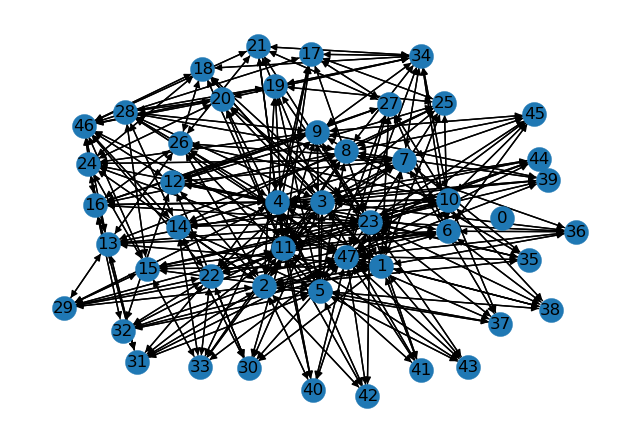

mask time: 0.05701470375061035
mask_test time: 0.018253564834594727
mask time: 0.08546137809753418
mask_test time: 0.00896596908569336
mask time: 0.018375396728515625
mask_test time: 0.0036394596099853516
mask time: 0.023618221282958984
mask_test time: 0.00891423225402832
mask time: 0.05859518051147461
mask_test time: 0.008552312850952148
mask time: 0.04838085174560547
mask_test time: 0.01390218734741211
mask time: 0.015514373779296875
mask_test time: 0.00396418571472168
mask time: 0.01999974250793457
mask_test time: 0.004099130630493164
mask time: 0.07089734077453613
mask_test time: 0.008986234664916992
mask time: 0.033965110778808594
mask_test time: 0.004621982574462891
mask time: 0.04213452339172363
mask_test time: 0.012253522872924805
mask time: 0.015377044677734375
mask_test time: 0.0054814815521240234
mask time: 0.010143756866455078
mask_test time: 0.002810239791870117
mask time: 0.0028018951416015625
mask_test time: 0.0015292167663574219
mask time: 0.03907132148742676
mask_test 

In [54]:
# 对mask及其依赖函数的测试
import functools
import time
import dgl
import torch
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(g):
    nx_g = g.to_networkx()
    # 创建matplotlib图形对象
    fig, ax = plt.subplots()
    # 可视化networkx图
    pos = nx.kamada_kawai_layout(nx_g)
    nx.draw(nx_g, pos=pos, with_labels=True, ax=ax)
    plt.show()

def readDimacsInstance(filename):
    # print filename
    g = dgl.DGLGraph()
    fin = open(filename, 'r')
    for line in fin.readlines():
        sline = line.split()
        if line.startswith('e'):
            g.add_edges(int(sline[1]), int(sline[2]))
    fin.close()
    return g

#     return mask_nodes
@functools.lru_cache(maxsize=16)
def get_neighbors_right(graph:dgl.DGLGraph, nodes:torch.Tensor, adj_matrix:torch.Tensor=None):
    """获得一个中心点列表中所有中心点的邻居，不包括中心点本身，且去重
    Args:
        graph (dgl.DGLGraph): 图对象
        nodes (torch.Tensor): 中心节点张量，1*nodes_num
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    assert nodes.is_cuda == True
    # # print(type(graph))
    adj_matrix = graph.adjacency_matrix()
    # 判断adj_matrix的是否在GPU上
    # # print(adj_matrix.is_cuda)
    adj_matrix = adj_matrix.to(nodes.device)
    # adj_matrix = adj_matrix.to(nodes.device)
    # # print(adj_matrix.device)
    assert adj_matrix.is_cuda == True

    # 获得这些节点的邻居
    neighbors = adj_matrix.index_select(0, nodes)
    # 压缩稀疏矩阵
    neighbors = neighbors.coalesce()
    # neighbors.indices()返回一个2*neighbors_num的矩阵，2 * neighbors_num，第二行是所有邻居节点标号的横向拼接
    unique_neighbors = torch.unique(neighbors.indices()[1])

    return unique_neighbors

# 多重递归获得邻居节点
@functools.lru_cache(maxsize=16)
def get_all_neighbors_right(graph:dgl.DGLGraph, nodes:torch.Tensor, depth:int, adj_matrix:torch.Tensor=None):
    """多重递归获得邻居节点集合张量（逻辑上是集合，物理数据结构为torch.Tensor），且去重
    Args:
        graph (dgl.DGLGraph): 输入图
        nodes (torch.Tensor): 中心节点集合张量，1*nodes_num
        depth (int): 递归深度，为0时相当于点遮盖，直接返回nodes
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    if depth < 0:
        return torch.Tensor([]).to(nodes.device)
    if depth == 0:
        return nodes
    else:
        neighbors = get_neighbors_right(graph, nodes)
        neighbors = torch.cat((neighbors, nodes), dim=0)
        neighbors = torch.unique(neighbors)
        return get_all_neighbors_right(graph, neighbors, depth-1)



#     return mask_nodes
@functools.lru_cache(maxsize=16)
def get_neighbors(graph:dgl.DGLGraph, nodes:torch.Tensor, adj_matrix:torch.Tensor=None):
    """获得一个中心点列表中所有中心点的邻居，不包括中心点本身，且去重
    Args:
        graph (dgl.DGLGraph): 图对象
        nodes (torch.Tensor): 中心节点张量，1*nodes_num
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
    """
    assert nodes.is_cuda == True
    ## 用矩阵运算的方式找邻居
    one_hot_central_nodes = torch.eye(adj_matrix.shape[0]).to(nodes.device)[nodes]
    neighbors_idx = (one_hot_central_nodes @ adj_matrix).nonzero()
    neighbors_idx = neighbors_idx[:,1]
    unique_neighbors = torch.unique(neighbors_idx)

    return unique_neighbors

# 多重递归获得邻居节点
# @functools.lru_cache(maxsize=16)
def get_all_neighbors(graph:dgl.DGLGraph, nodes:torch.Tensor, depth:int, adj_matrix:torch.Tensor=None):
    """多重递归获得邻居节点集合张量（逻辑上是集合，物理数据结构为torch.Tensor），且去重
    Args:
        graph (dgl.DGLGraph): 输入图
        nodes (torch.Tensor): 中心节点集合张量，1*nodes_num
        depth (int): 递归深度，为0时相当于点遮盖，直接返回nodes
    Returns:
        torch.Tensor: 所有中心点的邻居节点组成的无重复节点张量, 1*neighbors_num
        torch.Tensor: 每层外扩获得的邻居节点组成的无重复节点张量, depth*neighbors_num，0位置是第一层的邻居，1位置是第二层的邻居，以此类推
    """
    if adj_matrix == None:
        adj_matrix = graph.adjacency_matrix().to_dense().to(nodes.device)
    if depth < 0:
        return torch.Tensor([]).to(nodes.device)
    if depth == 0:
        return nodes
    else:
        level_neighbors = [] # 用于存储每一层的邻居
        level_neighbors.append(nodes) # 用level_neighbors[0]存储中心点
        one_hot_central_nodes = torch.eye(adj_matrix.shape[0]).to(nodes.device)[nodes]
        current_mat = one_hot_central_nodes @ adj_matrix
        current_neighbors = (current_mat).nonzero()
        neighbors = current_neighbors[:,1]
        neighbors = torch.cat((neighbors, level_neighbors[0]), dim=0)
        neighbors = torch.unique(neighbors)
        # neighbors = torch.unique(neighbors)
        level_neighbors.append(neighbors)
        for i in range(2, depth + 1):
            current_mat = current_mat @ adj_matrix
            current_neighbors = current_mat.nonzero()
            neighbors = current_neighbors[:,1]
            neighbors = torch.cat((neighbors, level_neighbors[i - 1]), dim=0)
            neighbors = torch.unique(neighbors)
            # neighbors = torch.masked_select(neighbors, torch.logical_not(torch.isin(neighbors, level_neighbors[i - 1])))
            level_neighbors.append(neighbors)
        assert neighbors.is_cuda == True
        # print("level_neighbors: ", level_neighbors)
        # print("central_nodes: ", nodes)
        return neighbors, level_neighbors

def mask_right(g:dgl.DGLGraph, x:torch.Tensor, num, depth, ring_width, get_all_neighbors, central_nodes=None):
    """遮盖子图，返回遮盖节点集合和中心节点集合
    Args:
        g (dgl.DGLGraph): 输入图
        x (torch.Tensor): 特征张量
        num (int): 随机遮盖的子图数量（中心点数量）
        depth (int, optional): 遮盖节点的邻居深度. Defaults to 1.
    Returns:
        torch.Tensor: mask_nodes, 遮盖节点集合
        torch.Tensor: central_nodes, 中心节点集合，可以去除，仅用在需要查看中心节点特征的情况下，猜测当gcn层数为3时，递归深度低于3就可能导致中心节点特征丢失 todo
    """
    assert 1 <= ring_width <= depth + 1, "ring_width must be in [1, depth + 1]"
    num_nodes = g.num_nodes()
    adj_matrix = g.adjacency_matrix().to_dense().to(x.device)

    if central_nodes == None:
        perm = torch.randperm(num_nodes, device=x.device)
        central_nodes = perm[: num]

    # print(central_nodes.device)
    assert type(central_nodes) == torch.Tensor
    # 判断central_nodes的shape为1*num
    central_nodes = central_nodes.to(x.device)
    # print(nodes)
    assert central_nodes.is_cuda == True

    # 外圆节点集合(含中心点)
    mask_nodes_out = get_all_neighbors(g, central_nodes, depth, adj_matrix)
    assert type(mask_nodes_out) == torch.Tensor

    # 内圆节点集合(含中心点)
    not_mask_nodes = get_all_neighbors(g, central_nodes,depth - ring_width, adj_matrix)
    # not_mask_nodes = torch.cat((central_nodes, not_mask_nodes), dim=0)
    # not_mask_nodes = torch.unique(not_mask_nodes)

    # 环形应遮盖节点集合，有于torch的集合操作，返回的mask_nodes一定是无重复的
    # mask_nodes = torch.masked_select(mask_nodes_out, torch.isin(mask_nodes_out, not_mask_nodes))
    mask_nodes = torch.masked_select(mask_nodes_out, torch.logical_not(torch.isin(mask_nodes_out, not_mask_nodes)))

    # mask_nodes可能没有元素，这种情况在没有邻居的情况下会出现，此时环内可能没有节点，这种情况应该返回空集

    return mask_nodes, central_nodes

def mask(g:dgl.DGLGraph, x:torch.Tensor, num, depth, ring_width, get_all_neighbors, central_nodes=None):
    """遮盖子图，返回遮盖节点集合和中心节点集合
    1. 此处采用的方式是将两个圆形子图做集合差，得到环形子图
    2. 还存在一种方式是将多个不同距离的邻居集合做集合并，得到环形子图
    采用 1 会出现如下问题：
        对于图:
        1-2-3
        1-3
        从 1 出发到 3 有两条路径，当我们取 depth = 2，ring_width = 1 时，我们得到 Mask_nodes 为空集
        这可能会导致遮盖的点集较少，且无法成为一个严格的环
    采用 2 会出现如下问题：
        对于图:
        1-2-3-4-5
        从 1 出发，当我们取 depth = 4，ring_width = 1 时，计算距离为2的邻居时可能会走“回头路”（1->2->1）这会导致出现一些很奇怪的现象，找距离固定的邻居时候出现回头，同一距离的邻居点形成类似水波涟漪的同心环结构，遮盖的点稀疏且有一定规律，利于重建
        对于图:
        1-2 --- 3 --- 4
         \  \   /   /
          \ 7 - 5 /
            ---8-- 
        从 1 出发，当我们取 depth = 3，ring_width = 1 时，计算距离为2的邻居时可能会走“回头路”，导致 2345 全部被遮，这会导致被遮盖的点过于集中，遮盖的时候丢失过多信息
    综上，我们认为 1 更加稳定一些，对 2 来说，同一种方法在不同的图上表现出的效果各不相同，可以作为未来的尝试
    Args:
        g (dgl.DGLGraph): 输入图
        x (torch.Tensor): 特征张量
        num (int): 随机遮盖的子图数量（中心点数量）
        depth (int, optional): 遮盖节点的邻居深度. Defaults to 1.
    Returns:
        torch.Tensor: mask_nodes, 遮盖节点集合
        torch.Tensor: central_nodes, 中心节点集合，可以去除，仅用在需要查看中心节点特征的情况下，猜测当gcn层数为3时，递归深度低于3就可能导致中心节点特征丢失 todo
    """
    assert 1 <= ring_width <= depth + 1, "ring_width must be in [1, depth + 1]"
    num_nodes = g.num_nodes()
    adj_matrix = g.adjacency_matrix().to_dense().to(x.device)

    if central_nodes == None:
        perm = torch.randperm(num_nodes, device=x.device)
        central_nodes = perm[: num]

    # print(central_nodes.device)
    assert type(central_nodes) == torch.Tensor
    # 判断central_nodes的shape为1*num
    central_nodes = central_nodes.to(x.device)
    # print(nodes)
    assert central_nodes.is_cuda == True

    # 外圆节点集合(含中心点)
    connected_nodes_out, level_neighbors = get_all_neighbors(g, central_nodes, depth, adj_matrix)
    assert type(connected_nodes_out) == torch.Tensor
    mask_nodes_out = torch.cat((central_nodes, connected_nodes_out), dim=0)
    mask_nodes_out = torch.unique(mask_nodes_out)

    # 内圆节点集合(含中心点)
    if (depth - ring_width) >= 0:
        not_mask_nodes = level_neighbors[depth - ring_width]
    else:
        not_mask_nodes = torch.Tensor([]).to(x.device) 



    # not_mask_nodes = get_all_neighbors(g, central_nodes,depth - ring_width, adj_matrix)
    # not_mask_nodes = torch.cat((central_nodes, not_mask_nodes), dim=0)
    # not_mask_nodes = torch.unique(not_mask_nodes)

    # 环形应遮盖节点集合，有于torch的集合操作，返回的mask_nodes一定是无重复的
    # mask_nodes = torch.masked_select(mask_nodes_out, torch.isin(mask_nodes_out, not_mask_nodes))
    mask_nodes = torch.masked_select(mask_nodes_out, torch.logical_not(torch.isin(mask_nodes_out, not_mask_nodes)))

    return mask_nodes, central_nodes


import torch
import networkx as nx
import matplotlib.pyplot as plt
import dgl
# import numpy as np

plt.style.use('seaborn')

print(torch.__version__)
g = dgl.DGLGraph()

# # 小型测试图
# g.add_edges(
#     [1,1,2,2,4,5,5, 0],
#     [7,3,3,4,5,8,6, 7]
# )


# 大型测试图
## 加载 col 格式的图数据集
g = readDimacsInstance("myciel5.col")
## 将数据集转换为 dgl.graph 对象

g = dgl.to_bidirected(g)

# print(g)

visualize_graph(g)

g = g.to(torch.device('cuda'))
temp_tensor = torch.tensor([1,2,3,4,5,6,7,8,9,10]).to(torch.device('cuda'))

# # 矩阵法找邻居原型demo
# central_nodes = torch.tensor([1], dtype=torch.int64).to(torch.device('cuda'))
# print("central_nodes:", central_nodes)
# print(g.adjacency_matrix().to_dense())
# adj_matrix = g.adjacency_matrix().to_dense()
# ## 用矩阵运算的方式找邻居
# one_hot_central_nodes = torch.eye(adj_matrix.shape[0])[central_nodes]
# print(one_hot_central_nodes)
# print(one_hot_central_nodes @ adj_matrix)
# neighbors_idx = (one_hot_central_nodes @ adj_matrix).nonzero()
# neighbors_idx = neighbors_idx[:,1]
# print(neighbors_idx)
# neighbors_idx2 = (one_hot_central_nodes @ adj_matrix @ adj_matrix).nonzero()
# neighbors_idx2 = neighbors_idx2[:,1]
# print(neighbors_idx2)


# 开始测试
test_times = 1000
num = 1
## 有效测试次数
effective_test_times = 0
for iter in range(test_times):
    depth = random.randint(1, 15)
    # depth = 3
    ring_width = random.randint(1, depth + 1)
    # ring_width = 1

    log = open("log.txt", "w")
    
    central_nodes = torch.randint(0, g.num_nodes(), (num, ), dtype=torch.int64).to(torch.device('cuda'))
    log.write(f"central_nodes: {central_nodes}\n")
    start_time = time.time()
    mask_nodes, central_nodes = mask_right(g, temp_tensor, num, depth, ring_width, get_all_neighbors_right, central_nodes)
    print(f"mask time: {time.time() - start_time}")
    start_time = time.time()
    mask_nodes_test, central_nodes_test = mask(g, temp_tensor, num, depth, ring_width, get_all_neighbors, central_nodes)
    print(f"mask_test time: {time.time() - start_time}")
    if (torch.equal(central_nodes, central_nodes_test)):
        effective_test_times += 1 
        # print("mask: ", mask_nodes)
        # print("mask_test: ", mask_nodes_test)
        # print("central:", central_nodes)
        # print("central_test: ", central_nodes_test)
        assert torch.equal(mask_nodes, mask_nodes_test), f"mask_nodes: {mask_nodes}, mask_nodes_test: {mask_nodes_test}\n\ncentral_nodes: {central_nodes}\n\ndepth: {depth},ring_width: {ring_width}\n\n"
        log.write(f"mask_nodes: {mask_nodes}\n")
        log.write(f"mask_nodes_test: {mask_nodes_test}\n\n") 
        assert torch.equal(central_nodes, central_nodes_test), (central_nodes, central_nodes_test)
log.close()
print(f"effective_test_times/test_times: {effective_test_times}/{test_times}")